In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder


#Read the CSV file
df = pd.read_csv('/content/drive/MyDrive/UAV/Ranked_UAV_QoS_Dataset-_1_.csv')





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.describe()


,ID,Latency,Throughput,Packet Delivery Ratio (PDR),Jitter
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.511977,0.505723,0.503497,0.509741
std,288.819436,0.293580,0.293306,0.291312,0.286804
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,250.750000,0.256659,0.238764,0.261913,0.262304
50%,500.500000,0.505394,0.517484,0.501701,0.515844
75%,750.250000,0.767516,0.760139,0.760759,0.758488
max,1000.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           1000 non-null   int64  
 1   Latency                      1000 non-null   float64
 2   Throughput                   1000 non-null   float64
 3   Packet Delivery Ratio (PDR)  1000 non-null   float64
 4   Jitter                       1000 non-null   float64
 5   Rank                         1000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/UAV/Ranked_UAV_QoS_Dataset-_1_.csv')

# 1. Check for missing values
assert df.isnull().sum().sum() == 0, "Dataset contains missing values."

# 2. Encode the categorical 'Rank' column
label_encoder = LabelEncoder()
df['Rank'] = label_encoder.fit_transform(df['Rank'])

# 3. Separate features and target
X = df.drop(columns=['ID', 'Rank'])
y = df['Rank']

# 4. Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# 6. Combine resampled features and target into a single DataFrame for saving
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Rank'])
cleaned_data = pd.concat([X_resampled_df, y_resampled_df], axis=1)

Save the cleaned dataset to Google Drive
output_path = '/content/drive/MyDrive/UAV/Cleaned_Ranked_UAV_QoS_Dataset.csv'
cleaned_data.to_csv(output_path, index=False)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cleaned dataset saved at: /content/drive/MyDrive/UAV/Cleaned_Ranked_UAV_QoS_Dataset.csv


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import time

# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/UAV/Cleaned_Ranked_UAV_QoS_Dataset.csv')

# Separate features and target
X = df.drop(columns=['Rank'])
y = df['Rank']

# Label encode the target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
n_classes = len(np.unique(y))

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode target for neural networks
y_train_oh = to_categorical(y_train, num_classes=n_classes)
y_val_oh = to_categorical(y_val, num_classes=n_classes)
y_test_oh = to_categorical(y_test, num_classes=n_classes)

# Define the MLP model
def create_mlp_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.4),
        LSTM(64, activation='tanh'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize result storage
results = []

# MLP Model
print("Training MLP model...")
mlp_model = create_mlp_model(input_shape=(X_train.shape[1],), num_classes=n_classes)
try:
    start_time = time.time()
    mlp_model.fit(X_train, y_train_oh, validation_data=(X_val, y_val_oh), batch_size=128, epochs=50, verbose=1)
    train_time = time.time() - start_time
    start_time = time.time()
    mlp_predictions = np.argmax(mlp_model.predict(X_test), axis=1)
    test_time = time.time() - start_time
    results.append([
        "MLP",
        accuracy_score(y_test, mlp_predictions),
        recall_score(y_test, mlp_predictions, average='weighted'),
        precision_score(y_test, mlp_predictions, average='weighted'),
        f1_score(y_test, mlp_predictions, average='weighted'),
        train_time,
        test_time
    ])
except Exception as e:
    print(f"Error training MLP model: {e}")

# SVM Model
print("Training SVM model...")
svm_model = SVC(kernel='rbf', probability=True)
try:
    start_time = time.time()
    svm_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    start_time = time.time()
    svm_predictions = svm_model.predict(X_test)
    test_time = time.time() - start_time
    results.append([
        "SVM",
        accuracy_score(y_test, svm_predictions),
        recall_score(y_test, svm_predictions, average='weighted'),
        precision_score(y_test, svm_predictions, average='weighted'),
        f1_score(y_test, svm_predictions, average='weighted'),
        train_time,
        test_time
    ])
except Exception as e:
    print(f"Error training SVM model: {e}")

# Random Forest Model
print("Training Random Forest model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
try:
    start_time = time.time()
    rf_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    start_time = time.time()
    rf_predictions = rf_model.predict(X_test)
    test_time = time.time() - start_time
    results.append([
        "Random Forest",
        accuracy_score(y_test, rf_predictions),
        recall_score(y_test, rf_predictions, average='weighted'),
        precision_score(y_test, rf_predictions, average='weighted'),
        f1_score(y_test, rf_predictions, average='weighted'),
        train_time,
        test_time
    ])
except Exception as e:
    print(f"Error training Random Forest model: {e}")

# LSTM Model
print("Training LSTM model...")
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], 1), num_classes=n_classes)
try:
    start_time = time.time()
    lstm_model.fit(X_train_cnn, y_train_oh, validation_data=(X_val_cnn, y_val_oh), batch_size=128, epochs=50, verbose=1)
    train_time = time.time() - start_time
    start_time = time.time()
    lstm_predictions = np.argmax(lstm_model.predict(X_test_cnn), axis=1)
    test_time = time.time() - start_time
    results.append([
        "LSTM",
        accuracy_score(y_test, lstm_predictions),
        recall_score(y_test, lstm_predictions, average='weighted'),
        precision_score(y_test, lstm_predictions, average='weighted'),
        f1_score(y_test, lstm_predictions, average='weighted'),
        train_time,
        test_time
    ])
except Exception as e:
    print(f"Error training LSTM model: {e}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=[
    "Algo / Central Learning", "Accuracy", "Recall", "Precision", "F1 Score", "Training Time (s)", "Testing Time (s)"
])
print(results_df)

# Save results
try:
    results_df.to_csv('/content/drive/MyDrive/UAV/Model_Comparison_Results.csv', index=False)
    print("Results saved successfully to /content/drive/MyDrive/UAV/Model_Comparison_Results.csv")
except Exception as e:
    print(f"Error saving results: {e}")


Training MLP model...
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 491ms/step - accuracy: 0.4702 - loss: 1.1638 - val_accuracy: 0.7934 - val_loss: 0.9108
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7427 - loss: 0.6013 - val_accuracy: 0.9525 - val_loss: 0.7621
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8238 - loss: 0.4518 - val_accuracy: 0.8988 - val_loss: 0.6725
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8639 - loss: 0.3621 - val_accuracy: 0.8223 - val_loss: 0.6175
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8836 - loss: 0.3031 - val_accuracy: 0.7355 - val_loss: 0.5961
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9137 - loss: 0.2458 - val_accuracy: 0.7273 - val_loss: 0.5599
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9176 - loss: 0.2254 - val_accuracy: 0.6777 - val_loss: 0.5573
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9311 - loss: 0.2040 - val_a

Training MLP model...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 573ms/step - accuracy: 0.4602 - loss: 1.3223 - val_accuracy: 0.9174 - val_loss: 0.8900
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7506 - loss: 0.5827 - val_accuracy: 0.9318 - val_loss: 0.7332
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8234 - loss: 0.4276 - val_accuracy: 0.8574 - val_loss: 0.6345
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8700 - loss: 0.3407 - val_accuracy: 0.8058 - val_loss: 0.5858
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8974 - loss: 0.2716 - val_accuracy: 0.7438 - val_loss: 0.5669
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9094 - loss: 0.2611 - val_accuracy: 0.7273 - val_loss: 0.5415
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9142 - loss: 0.2278 - val_accuracy: 0.6880 - val_loss: 0.5321
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9291 - loss: 0.1896 

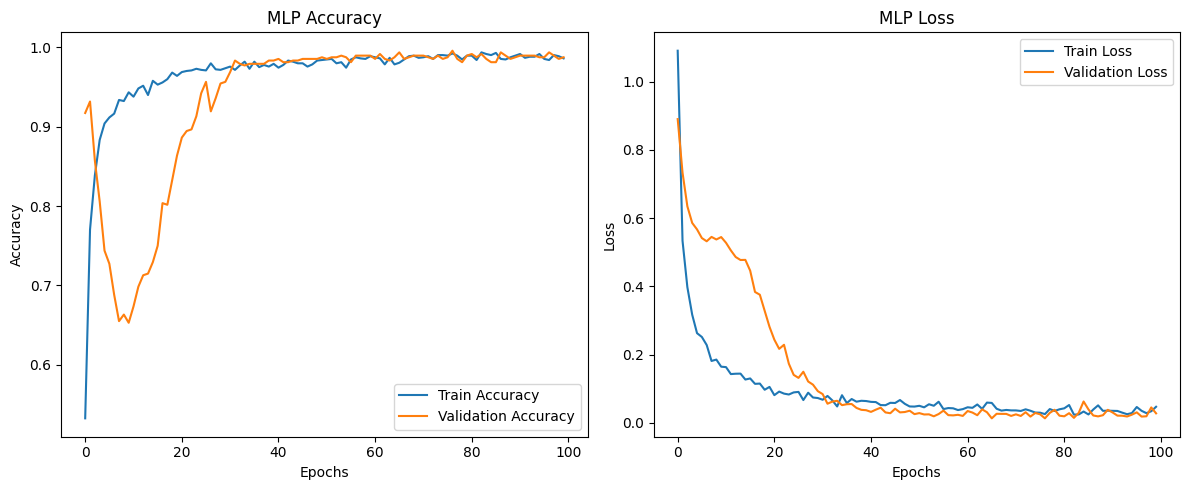

Training LSTM model...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.4615 - loss: 1.0757 - val_accuracy: 0.6591 - val_loss: 0.9784
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6589 - loss: 0.9207 - val_accuracy: 0.6550 - val_loss: 0.7122
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6460 - loss: 0.6580 - val_accuracy: 0.6653 - val_loss: 0.6047
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6898 - loss: 0.5671 - val_accuracy: 0.7603 - val_loss: 0.5101
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8102 - loss: 0.4898 - val_accuracy: 0.8037 - val_loss: 0.4266
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8446 - loss: 0.4055 - val_accuracy: 0.9277 - val_loss: 0.3184
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9312 - loss: 0.2844 - val_accuracy: 0.9380 - val_loss: 0.2085
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9504 - loss: 0.1780 -

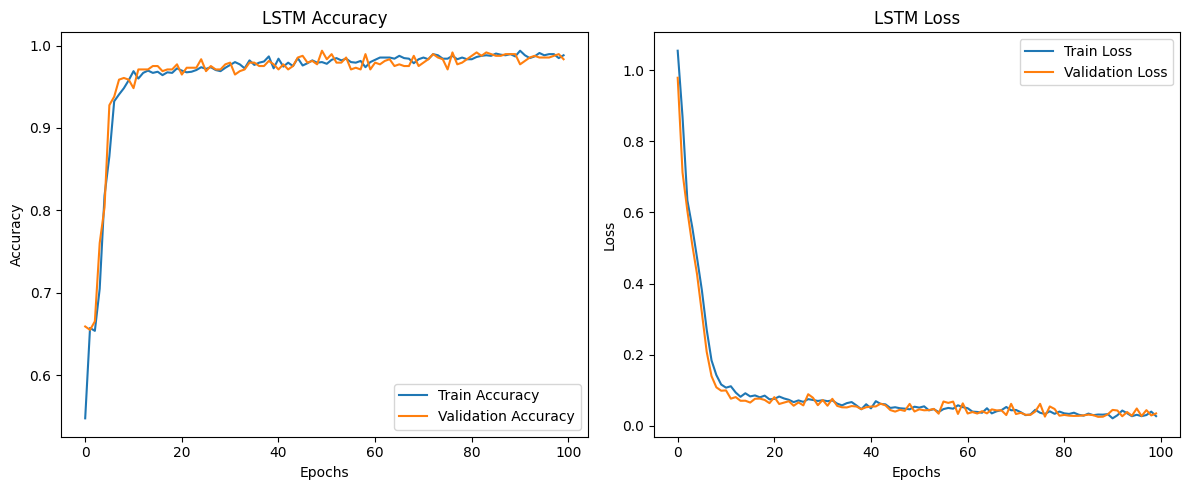

Training GRU model...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5295 - loss: 1.0312 - val_accuracy: 0.7190 - val_loss: 0.7799
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7114 - loss: 0.6992 - val_accuracy: 0.7541 - val_loss: 0.4646
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7908 - loss: 0.4418 - val_accuracy: 0.8471 - val_loss: 0.3238
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9033 - loss: 0.2927 - val_accuracy: 0.9380 - val_loss: 0.1968
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9410 - loss: 0.1829 - val_accuracy: 0.9545 - val_loss: 0.1248
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9482 - loss: 0.1413 - val_accuracy: 0.9628 - val_loss: 0.1016
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9566 - loss: 0.1203 - val_accuracy: 0.9545 - val_loss: 0.0988
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9641 - loss: 0.1011 

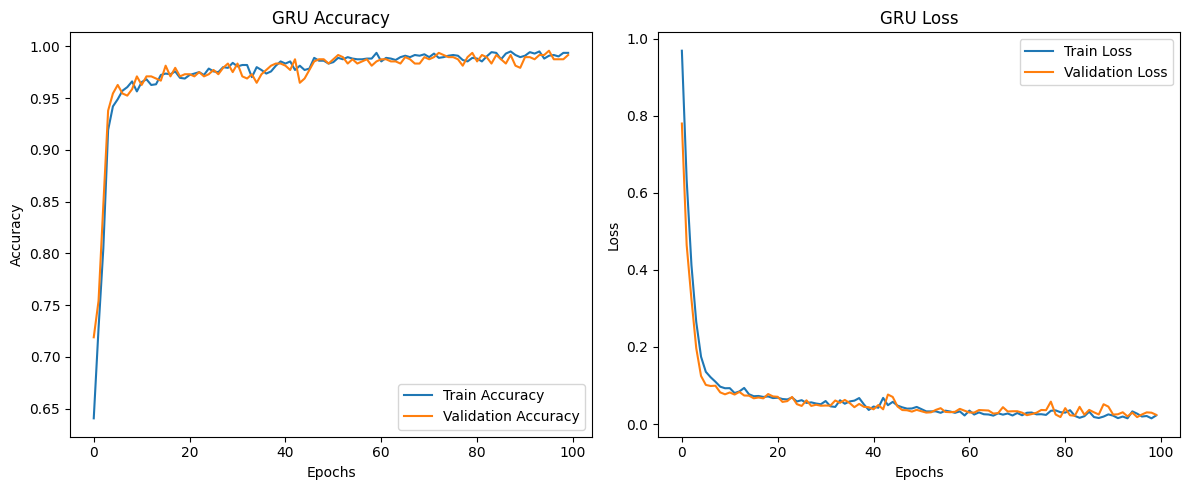

Training Naive Bayes model...
  Algo / Central Learning  Accuracy    Recall  Precision  F1 Score  \
0                     MLP  0.991736  0.991736   0.991824  0.991735   
1                    LSTM  0.989669  0.989669   0.989833  0.989668   
2                     GRU  0.989669  0.989669   0.989694  0.989663   
3             Naive Bayes  0.898760  0.898760   0.903223  0.899934   

   Training Time (s)  Testing Time (s)  
0          34.212915          1.336077  
1          20.562889          0.672630  
2          17.516061          0.352112  
3           0.002049          0.000469  
Results saved successfully to /content/drive/MyDrive/UAV/Model_Comparison_Results.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, GRU, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import time
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/UAV/Cleaned_Ranked_UAV_QoS_Dataset.csv')

# Separate features and target
X = df.drop(columns=['Rank'])
y = df['Rank']

# Label encode the target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
n_classes = len(np.unique(y))

# Train-test-validation split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# One-hot encode target for neural networks
y_train_oh = to_categorical(y_train, num_classes=n_classes)
y_val_oh = to_categorical(y_val, num_classes=n_classes)
y_test_oh = to_categorical(y_test, num_classes=n_classes)

# Define the MLP model
def create_mlp_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, activation='tanh', return_sequences=True),
        Dropout(0.4),
        LSTM(64, activation='tanh'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the GRU model
def create_gru_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        GRU(128, activation='tanh', return_sequences=True),
        Dropout(0.4),
        GRU(64, activation='tanh'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize result storage
results = []
def plot_metrics(history, model_name):
    plt.figure(figsize=(12, 5))
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP Model
print("Training MLP model...")
mlp_model = create_mlp_model(input_shape=(X_train.shape[1],), num_classes=n_classes)
try:
    start_time = time.time()
    mlp_history = mlp_model.fit(X_train, y_train_oh, validation_data=(X_val, y_val_oh), batch_size=128, epochs=100, verbose=1)
    train_time = time.time() - start_time
    start_time = time.time()
    mlp_predictions = np.argmax(mlp_model.predict(X_test), axis=1)
    test_time = time.time() - start_time
    results.append([
        "MLP",
        accuracy_score(y_test, mlp_predictions),
        recall_score(y_test, mlp_predictions, average='weighted'),
        precision_score(y_test, mlp_predictions, average='weighted'),
        f1_score(y_test, mlp_predictions, average='weighted'),
        train_time,
        test_time
    ])
    plot_metrics(mlp_history, "MLP")
except Exception as e:
    print(f"Error training MLP model: {e}")

# LSTM Model
print("Training LSTM model...")
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], 1), num_classes=n_classes)
try:
    X_train_lstm = X_train[..., np.newaxis]
    X_val_lstm = X_val[..., np.newaxis]
    X_test_lstm = X_test[..., np.newaxis]
    start_time = time.time()
    lstm_history = lstm_model.fit(X_train_lstm, y_train_oh, validation_data=(X_val_lstm, y_val_oh), batch_size=128, epochs=100, verbose=1)
    train_time = time.time() - start_time
    start_time = time.time()
    lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
    test_time = time.time() - start_time
    results.append([
        "LSTM",
        accuracy_score(y_test, lstm_predictions),
        recall_score(y_test, lstm_predictions, average='weighted'),
        precision_score(y_test, lstm_predictions, average='weighted'),
        f1_score(y_test, lstm_predictions, average='weighted'),
        train_time,
        test_time
    ])
    plot_metrics(lstm_history, "LSTM")
except Exception as e:
    print(f"Error training LSTM model: {e}")

# GRU Model
print("Training GRU model...")
gru_model = create_gru_model(input_shape=(X_train.shape[1], 1), num_classes=n_classes)
try:
    X_train_gru = X_train[..., np.newaxis]
    X_val_gru = X_val[..., np.newaxis]
    X_test_gru = X_test[..., np.newaxis]
    start_time = time.time()
    gru_history = gru_model.fit(X_train_gru, y_train_oh, validation_data=(X_val_gru, y_val_oh), batch_size=128, epochs=100, verbose=1)
    train_time = time.time() - start_time
    start_time = time.time()
    gru_predictions = np.argmax(gru_model.predict(X_test_gru), axis=1)
    test_time = time.time() - start_time
    results.append([
        "GRU",
        accuracy_score(y_test, gru_predictions),
        recall_score(y_test, gru_predictions, average='weighted'),
        precision_score(y_test, gru_predictions, average='weighted'),
        f1_score(y_test, gru_predictions, average='weighted'),
        train_time,
        test_time
    ])
    plot_metrics(gru_history, "GRU")
except Exception as e:
    print(f"Error training GRU model: {e}")

# Naive Bayes Model
print("Training Naive Bayes model...")
nb_model = GaussianNB()
try:
    start_time = time.time()
    nb_model.fit(X_train, y_train)
    train_time = time.time() - start_time
    start_time = time.time()
    nb_predictions = nb_model.predict(X_test)
    test_time = time.time() - start_time
    results.append([
        "Naive Bayes",
        accuracy_score(y_test, nb_predictions),
        recall_score(y_test, nb_predictions, average='weighted'),
        precision_score(y_test, nb_predictions, average='weighted'),
        f1_score(y_test, nb_predictions, average='weighted'),
        train_time,
        test_time
    ])
except Exception as e:
    print(f"Error training Naive Bayes model: {e}")

# Convert results to DataFrame and display
results_df = pd.DataFrame(results, columns=[
    "Algo / Central Learning", "Accuracy", "Recall", "Precision", "F1 Score", "Training Time (s)", "Testing Time (s)"
])
print(results_df)

# Save results
try:
    results_df.to_csv('/content/drive/MyDrive/UAV/Model_Comparison_Results.csv', index=False)
    print("Results saved successfully to /content/drive/MyDrive/UAV/Model_Comparison_Results.csv")
except Exception as e:
    print(f"Error saving results: {e}")


*********************
*********************
*********************
*********************
*********************
